<a href="https://colab.research.google.com/github/AkiraNom/data-analysis-notebook/blob/main/Bayesian_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Out-Of-Sample Prediction

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from scipy.special import expit as inverse_logit
from sklearn.metrics import RocCurveDisplay, accuracy_score, auc, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import pymc as pm
import pytensor.tensor as pt
import patsy

In [ ]:
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Data

**Target Classes:** <br>
>  **0** : setosa <br>
   **1** : versicolor <br>
   **2** : virginica  <br>

**Independent variables:**
> sepal length (cm) <br>
  sepal width (cm) <br>
  petal length (cm) <br>
  petal width (cm) <br>



In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(data = iris.data, columns=iris.feature_names)
df['target'] = iris.target
df.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [ ]:
df.describe()

sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)      target  
count        150.000000  150.000000  
mean           1.199333    1.000000  
std            0.762238    0.819232  
min            0.100000    0.000000  
25%            0.300000    0.000000  
50%            1.300000    1.000000  
75%            1.800000    2.000000  
max            2.500000    2.000000

## Data visualization

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:208: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  self._figure.subplots_adjust(right=right)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


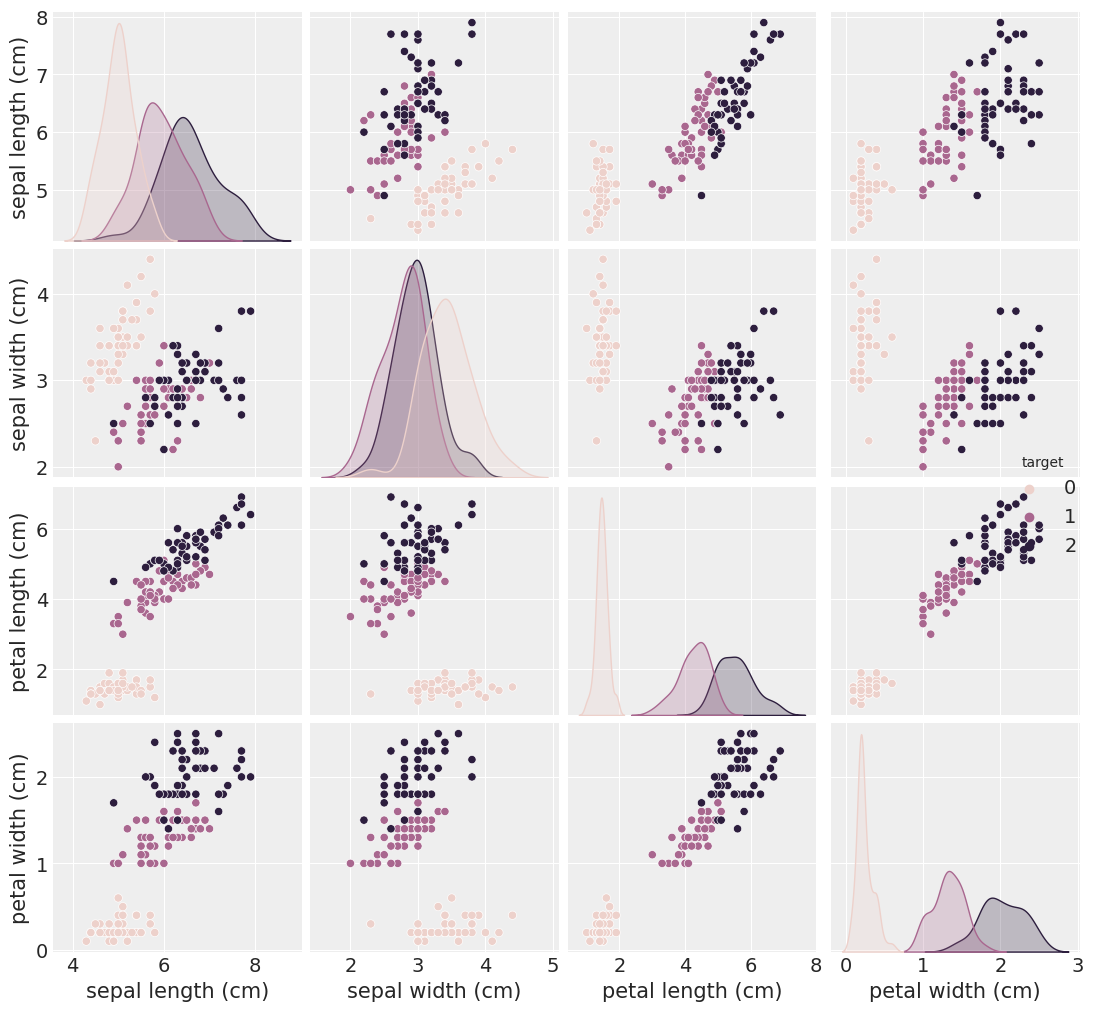

In [ ]:
sns.pairplot(data=df, hue='target',kind="scatter")

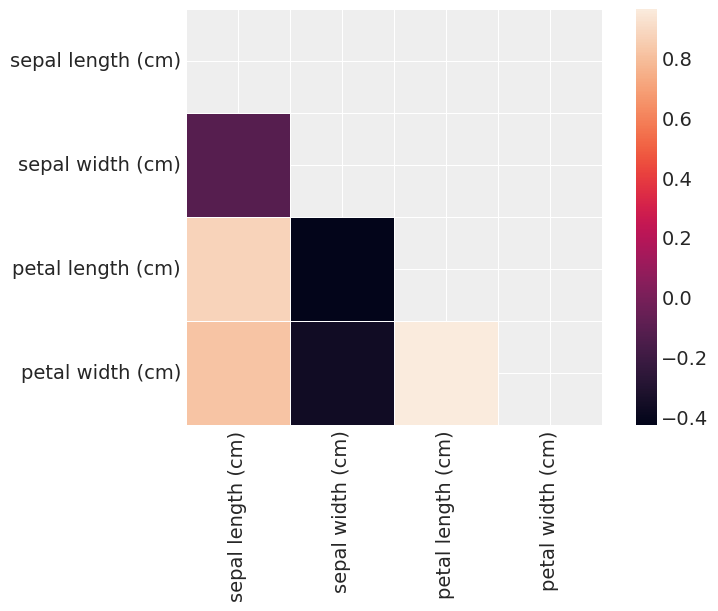

In [ ]:
# Heatkmap
corr=df.iloc[:, :-1].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

ax=sns.heatmap(corr, mask=mask,
            square=True, linewidths=.5)

## Data preparation for modeling

For binary classification, drop the target = 0 (setosa) from the dataset. <br>

**Old Target Classes:** <br>
>  **0** : setosa <br>
   **1** : versicolor <br>
   **2** : virginica  <br>

**New Target Classes:** <br>
   **0** : versicolor <br>
   **1** : virginica  <br>

In [ ]:
df = df[df['target']!=0]
df['target'] = df['target'] -1
df.head()

<ipython-input-9-dc20f268f699>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['target'] -1


sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
50                7.0               3.2                4.7               1.4   
51                6.4               3.2                4.5               1.5   
52                6.9               3.1                4.9               1.5   
53                5.5               2.3                4.0               1.3   
54                6.5               2.8                4.6               1.5   

    target  
50       0  
51       0  
52       0  
53       0  
54       0

In [ ]:
params = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

### Train-test split

In [ ]:
# Train-test split
X = df.iloc[:,:-1]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [ ]:
df

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
50                 7.0               3.2                4.7               1.4   
51                 6.4               3.2                4.5               1.5   
52                 6.9               3.1                4.9               1.5   
53                 5.5               2.3                4.0               1.3   
54                 6.5               2.8                4.6               1.5   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

     target  
50        0  
51        0  
52        0  
53        0  
54        0  
..      ...  
145       1  
146       1  
147       1  
148       1  
149       1  

[100 rows x 5 columns]

## Build a model

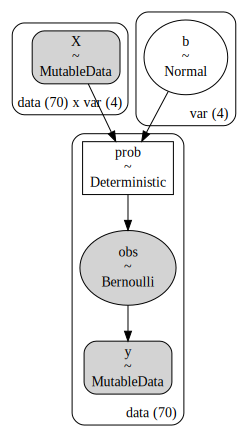

In [ ]:
mu = 0
std = 10**4

with pm.Model() as model:

    model.add_coord('data', X_train.index, mutable = True)
    model.add_coord('var', X_train.columns, mutable = True)

    # data
    x = pm.Data('X', X_train, dims=('data', 'var'), mutable=True)
    y = pm.Data('y', y_train, dims=('data',), mutable=True)

    # prior distribution
    # b0 = pm.Normal('b0', mu, std)
    beta =pm.Normal('b', mu=mu, sigma=std, dims='var')
    mu = pm.math.dot(x, beta)

    p = pm.Deterministic('prob',pm.math.invlogit(mu), dims=('data',))

    pm.Bernoulli('obs', p=p, observed=y, dims=('data',))


pm.model_to_graphviz(model)

In [ ]:
with model:
    idata = pm.sample(draws=25000, tune=1500)

In [ ]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

array([[<Axes: title={'center': 'b\nsepal length (cm)'}>,
        <Axes: title={'center': 'b\nsepal length (cm)'}>],
       [<Axes: title={'center': 'b\nsepal width (cm)'}>,
        <Axes: title={'center': 'b\nsepal width (cm)'}>],
       [<Axes: title={'center': 'b\npetal length (cm)'}>,
        <Axes: title={'center': 'b\npetal length (cm)'}>],
       [<Axes: title={'center': 'b\npetal width (cm)'}>,
        <Axes: title={'center': 'b\npetal width (cm)'}>]], dtype=object)

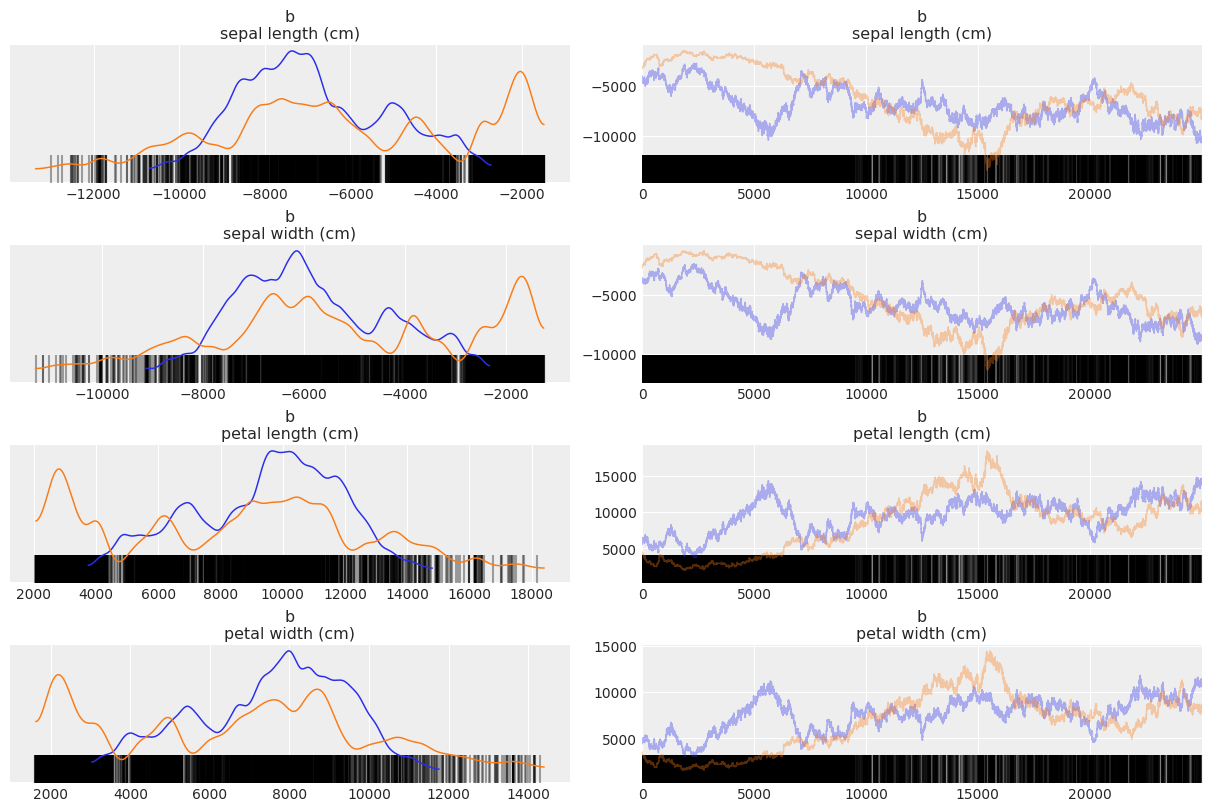

In [ ]:
az.plot_trace(idata, var_names=['b'], compact=False)

**Energy plot**

Plot energy transition distribution and marginal energy distribution in HMC algorithms.

This may help to diagnos poor exploration by gradient-based algorithms like HMC or NUTS.

When the two distirubitons are well-matched,the sampling using HMC or NUTS is good.  
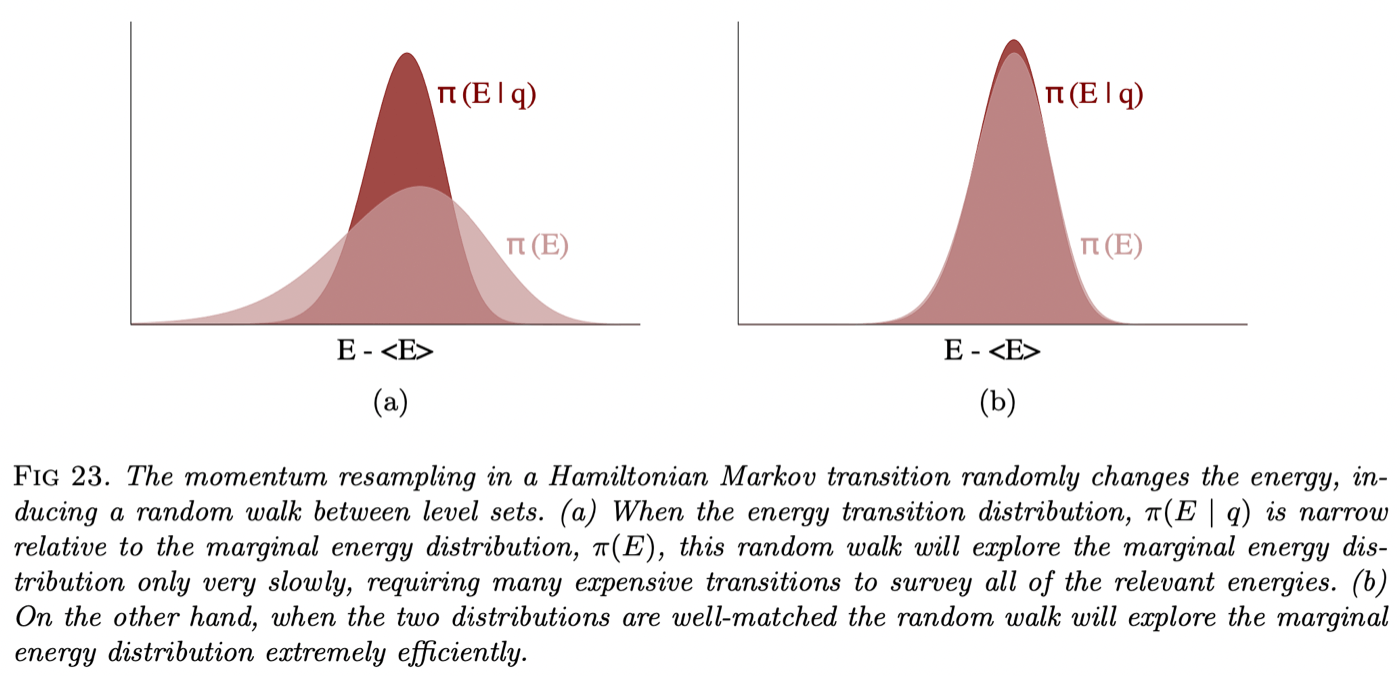

reference:
  1. [A conceptual introduction to Hamiltonian Monte Carlo](https://arxiv.org/pdf/1701.02434.pdf) by Michael Betancourt
  2. [arviz.plot_energy](https://python.arviz.org/en/stable/api/generated/arviz.plot_energy.html)

<Axes: >

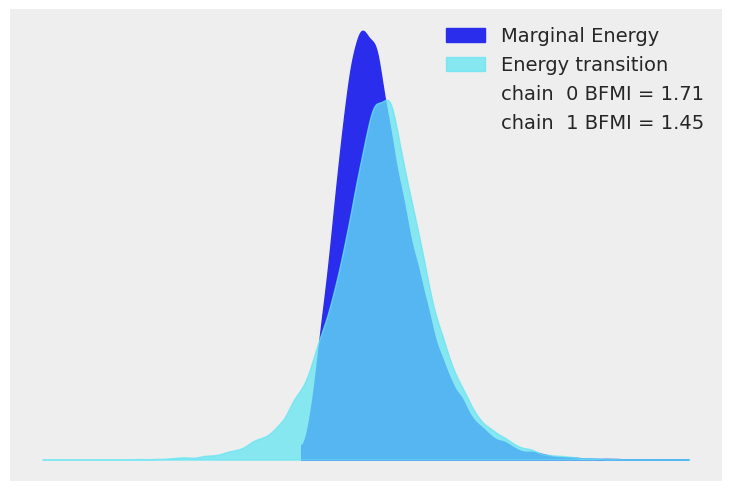

In [ ]:
az.plot_energy(idata)

## Evaluate posterior distribution

In [ ]:
az.summary(idata, var_names=['b'])

mean        sd    hdi_3%    hdi_97%  mcse_mean  \
b[sepal length (cm)] -6461.582  2376.430 -9935.630  -1642.116   1239.393   
b[sepal width (cm)]  -5500.996  2031.703 -8462.353  -1356.240   1059.747   
b[petal length (cm)]  8928.712  3284.576  2255.478  13725.425   1714.679   
b[petal width (cm)]   7093.095  2619.622  1825.256  10961.546   1361.916   

                       mcse_sd  ess_bulk  ess_tail  r_hat  
b[sepal length (cm)]   957.181       4.0      12.0   1.44  
b[sepal width (cm)]    818.462       4.0      12.0   1.44  
b[petal length (cm)]  1324.496       4.0      12.0   1.44  
b[petal width (cm)]   1051.152       4.0      12.0   1.43

array([<Axes: title={'center': 'b\nsepal length (cm)'}>,
       <Axes: title={'center': 'b\nsepal width (cm)'}>,
       <Axes: title={'center': 'b\npetal length (cm)'}>,
       <Axes: title={'center': 'b\npetal width (cm)'}>], dtype=object)

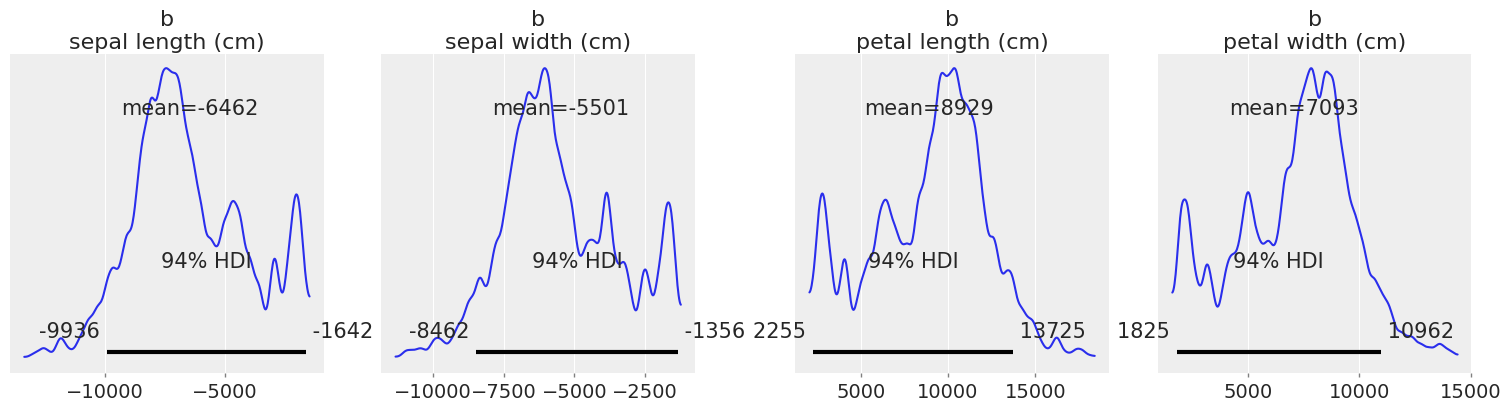

In [ ]:
az.plot_posterior(idata, var_names=['b'], figsize=(15, 4))

**Forest plot**

visualize the HDI intervals from a number of ditribution with Rhats.

reference: [az.plot_forest](https://python.arviz.org/en/stable/api/generated/arviz.plot_forest.html)

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

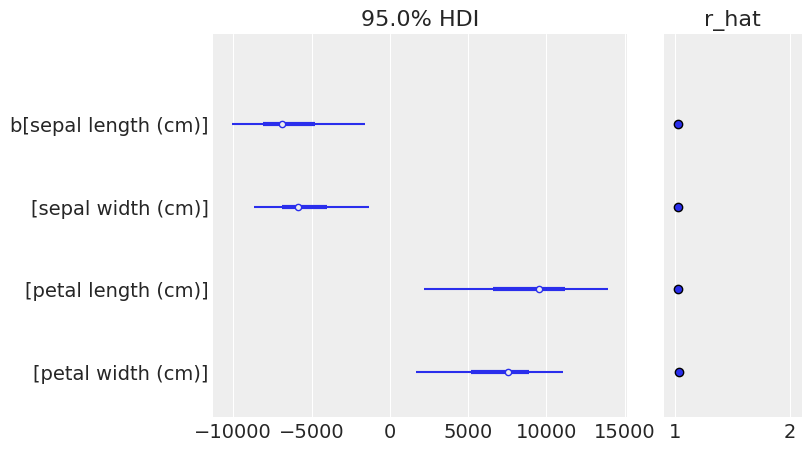

In [ ]:
az.plot_forest(idata, var_names=['b'], combined=True, hdi_prob=0.95, r_hat=True)

## Generate Out-Of-Sample Predictions

In [ ]:
with model:
    pm.set_data({'X': X_test,'y': y_test}, coords={'data': X_test.index})
    idata.extend(pm.sample_posterior_predictive(idata))

In [ ]:
# Compute the point prediction by taking the mean and defining the category via a threshold.
p_test_pred = idata.posterior_predictive["obs"].mean(dim=["chain", "draw"])
y_test_pred = (p_test_pred >= 0.5).astype("int")

## ModelEvaluation

### Accuray

In [ ]:
print(f"accuracy = {accuracy_score(y_true=y_test, y_pred=y_test_pred): 0.3f}")

accuracy =  0.933


### ROC

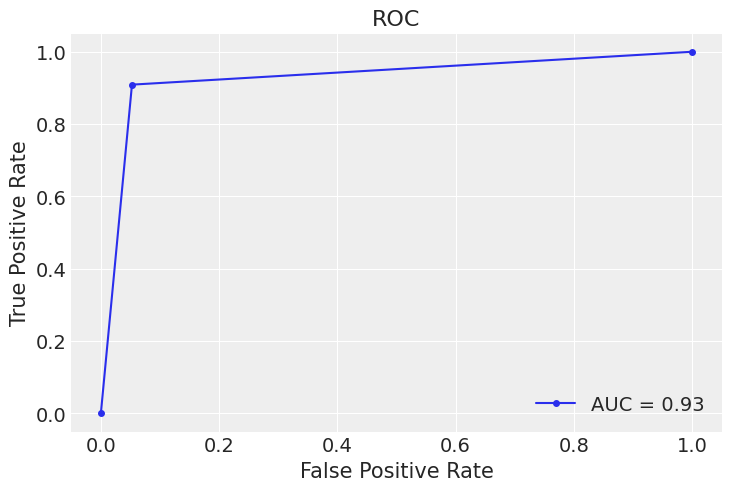

In [ ]:
fpr, tpr, thresholds = roc_curve(
    y_true=y_test, y_score=p_test_pred, pos_label=1, drop_intermediate=False
)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display = roc_display.plot(ax=ax, marker="o", markersize=4)
ax.set(title="ROC");

### Confusion matrix

The print_confusion_matrix function is taken from [shaypal5 github](https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823).

In [ ]:
# Source code credit for this function: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823

def print_confusion_matrix(confusion_matrix, class_names, figsize = (9,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Note that due to returning the created figure object, when this funciton is called in a
    notebook the figure willl be printed twice. To prevent this, either append ; to your
    function call, or modify the function by commenting out the return expression.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix.
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label', fontsize = 12)
    plt.xlabel('Predicted label', fontsize = 12)
    plt.title('Confusion Matrix', fontsize = 16)
    # Note that due to returning the created figure object, when this funciton is called in a notebook
    # the figure willl be printed twice. To prevent this, either append ; to your function call, or
    # modify the function by commenting out this return expression.
    # return fig

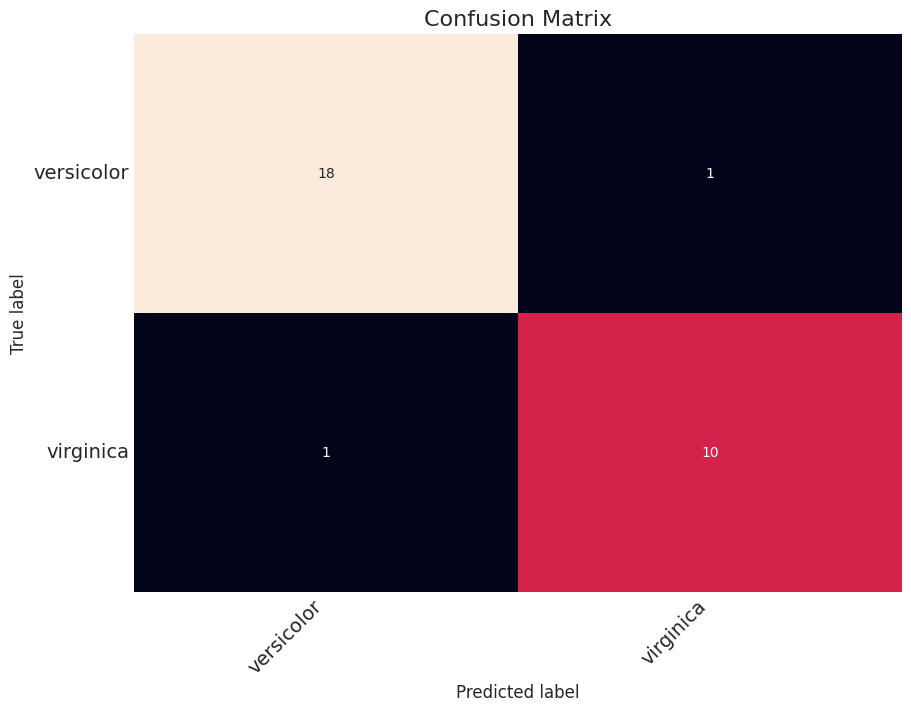

In [ ]:
print_confusion_matrix(confusion_matrix(y_test, y_test_pred), ['versicolor', 'virginica'])

### Classification report

In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.91      0.91      0.91        11

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



### Visualize the predicted labels and actural labels

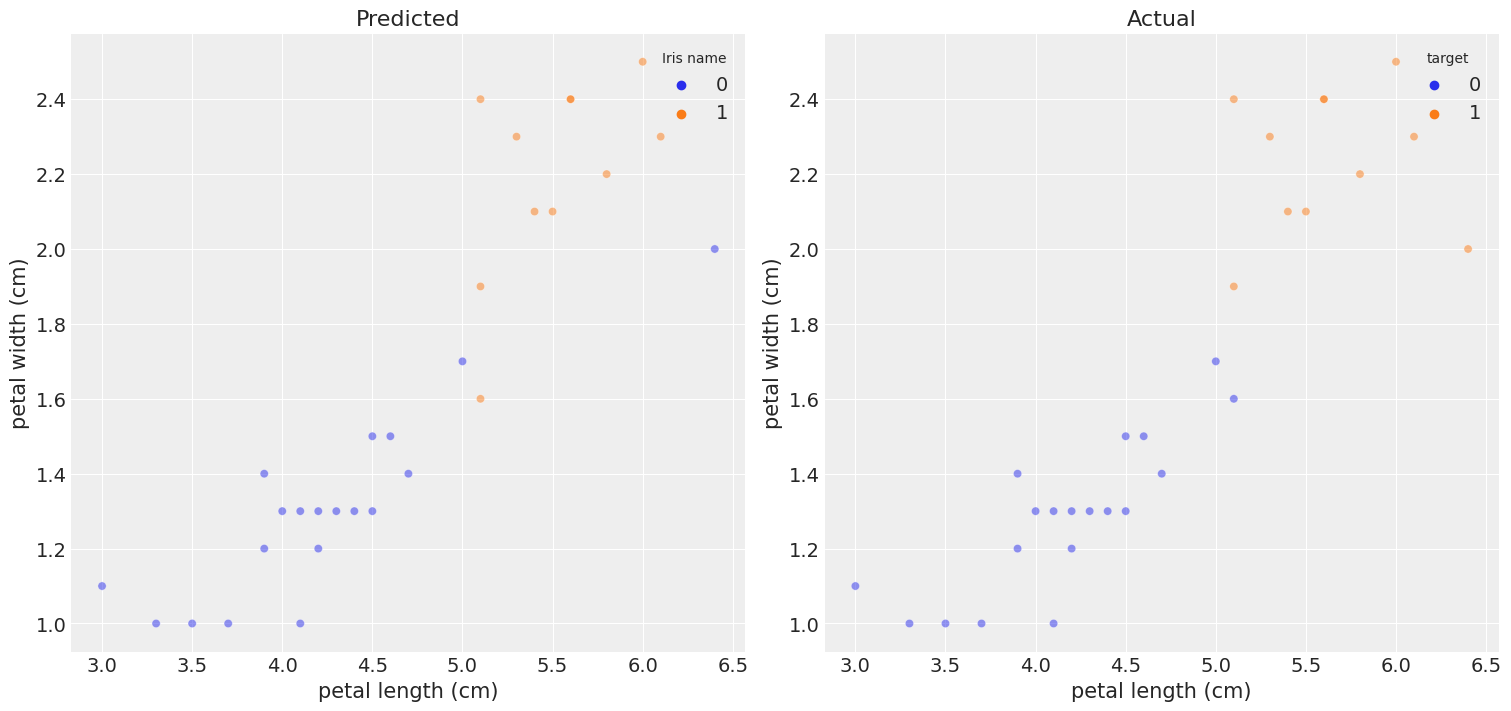

In [ ]:
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(1,2,1)
ax1 = sns.scatterplot(x = X_test['petal length (cm)'], y = X_test['petal width (cm)'], hue = y_test_pred, alpha = 0.5)
plt.title('Predicted')
plt.legend(title='Iris name')

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.scatterplot(x = X_test['petal length (cm)'], y = X_test['petal width (cm)'], hue = y_test, alpha = 0.5)
plt.title('Actual');

# Bayesian Logistic Regression Classification using coronary artery disease

The data set CHDdata.csv contains <br>
<br>
**Target** <br>
>* the diagnosis of coronary heart disease (CHD) <br>

**Independent variables**

> * systolic blood pressure,
* yearly tobacco use (in kg),
* low density lipoprotein (Idl),
* adiposity, family history (0 or 1),
* type A personality score (typea),
* obesity (body mass index),
* alcohol use,
* age,


## Dataset

In [ ]:
df_chd = pd.read_csv("CHDdata.csv")
df_chd.head()

sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  chd
0  160    12.00  5.73      23.11  Present     49    25.30    97.20   52    1
1  144     0.01  4.41      28.61   Absent     55    28.87     2.06   63    1
2  118     0.08  3.48      32.28  Present     52    29.14     3.81   46    0
3  170     7.50  6.41      38.03  Present     51    31.99    24.26   58    1
4  134    13.60  3.50      27.78  Present     60    25.99    57.34   49    1

In [ ]:
df_chd.describe()

sbp     tobacco         ldl   adiposity       typea     obesity  \
count  462.000000  462.000000  462.000000  462.000000  462.000000  462.000000   
mean   138.326840    3.635649    4.740325   25.406732   53.103896   26.044113   
std     20.496317    4.593024    2.070909    7.780699    9.817534    4.213680   
min    101.000000    0.000000    0.980000    6.740000   13.000000   14.700000   
25%    124.000000    0.052500    3.282500   19.775000   47.000000   22.985000   
50%    134.000000    2.000000    4.340000   26.115000   53.000000   25.805000   
75%    148.000000    5.500000    5.790000   31.227500   60.000000   28.497500   
max    218.000000   31.200000   15.330000   42.490000   78.000000   46.580000   

          alcohol         age         chd  
count  462.000000  462.000000  462.000000  
mean    17.044394   42.816017    0.346320  
std     24.481059   14.608956    0.476313  
min      0.000000   15.000000    0.000000  
25%      0.510000   31.000000    0.000000  
50%      7.510000   45.000000    0.000000  
75%     23.892500   55.000000    1.000000  
max    147.190000   64.000000    1.000000

In [ ]:
df_chd.isna().sum()

sbp          0
tobacco      0
ldl          0
adiposity    0
famhist      0
typea        0
obesity      0
alcohol      0
age          0
chd          0
dtype: int64

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:208: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  self._figure.subplots_adjust(right=right)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


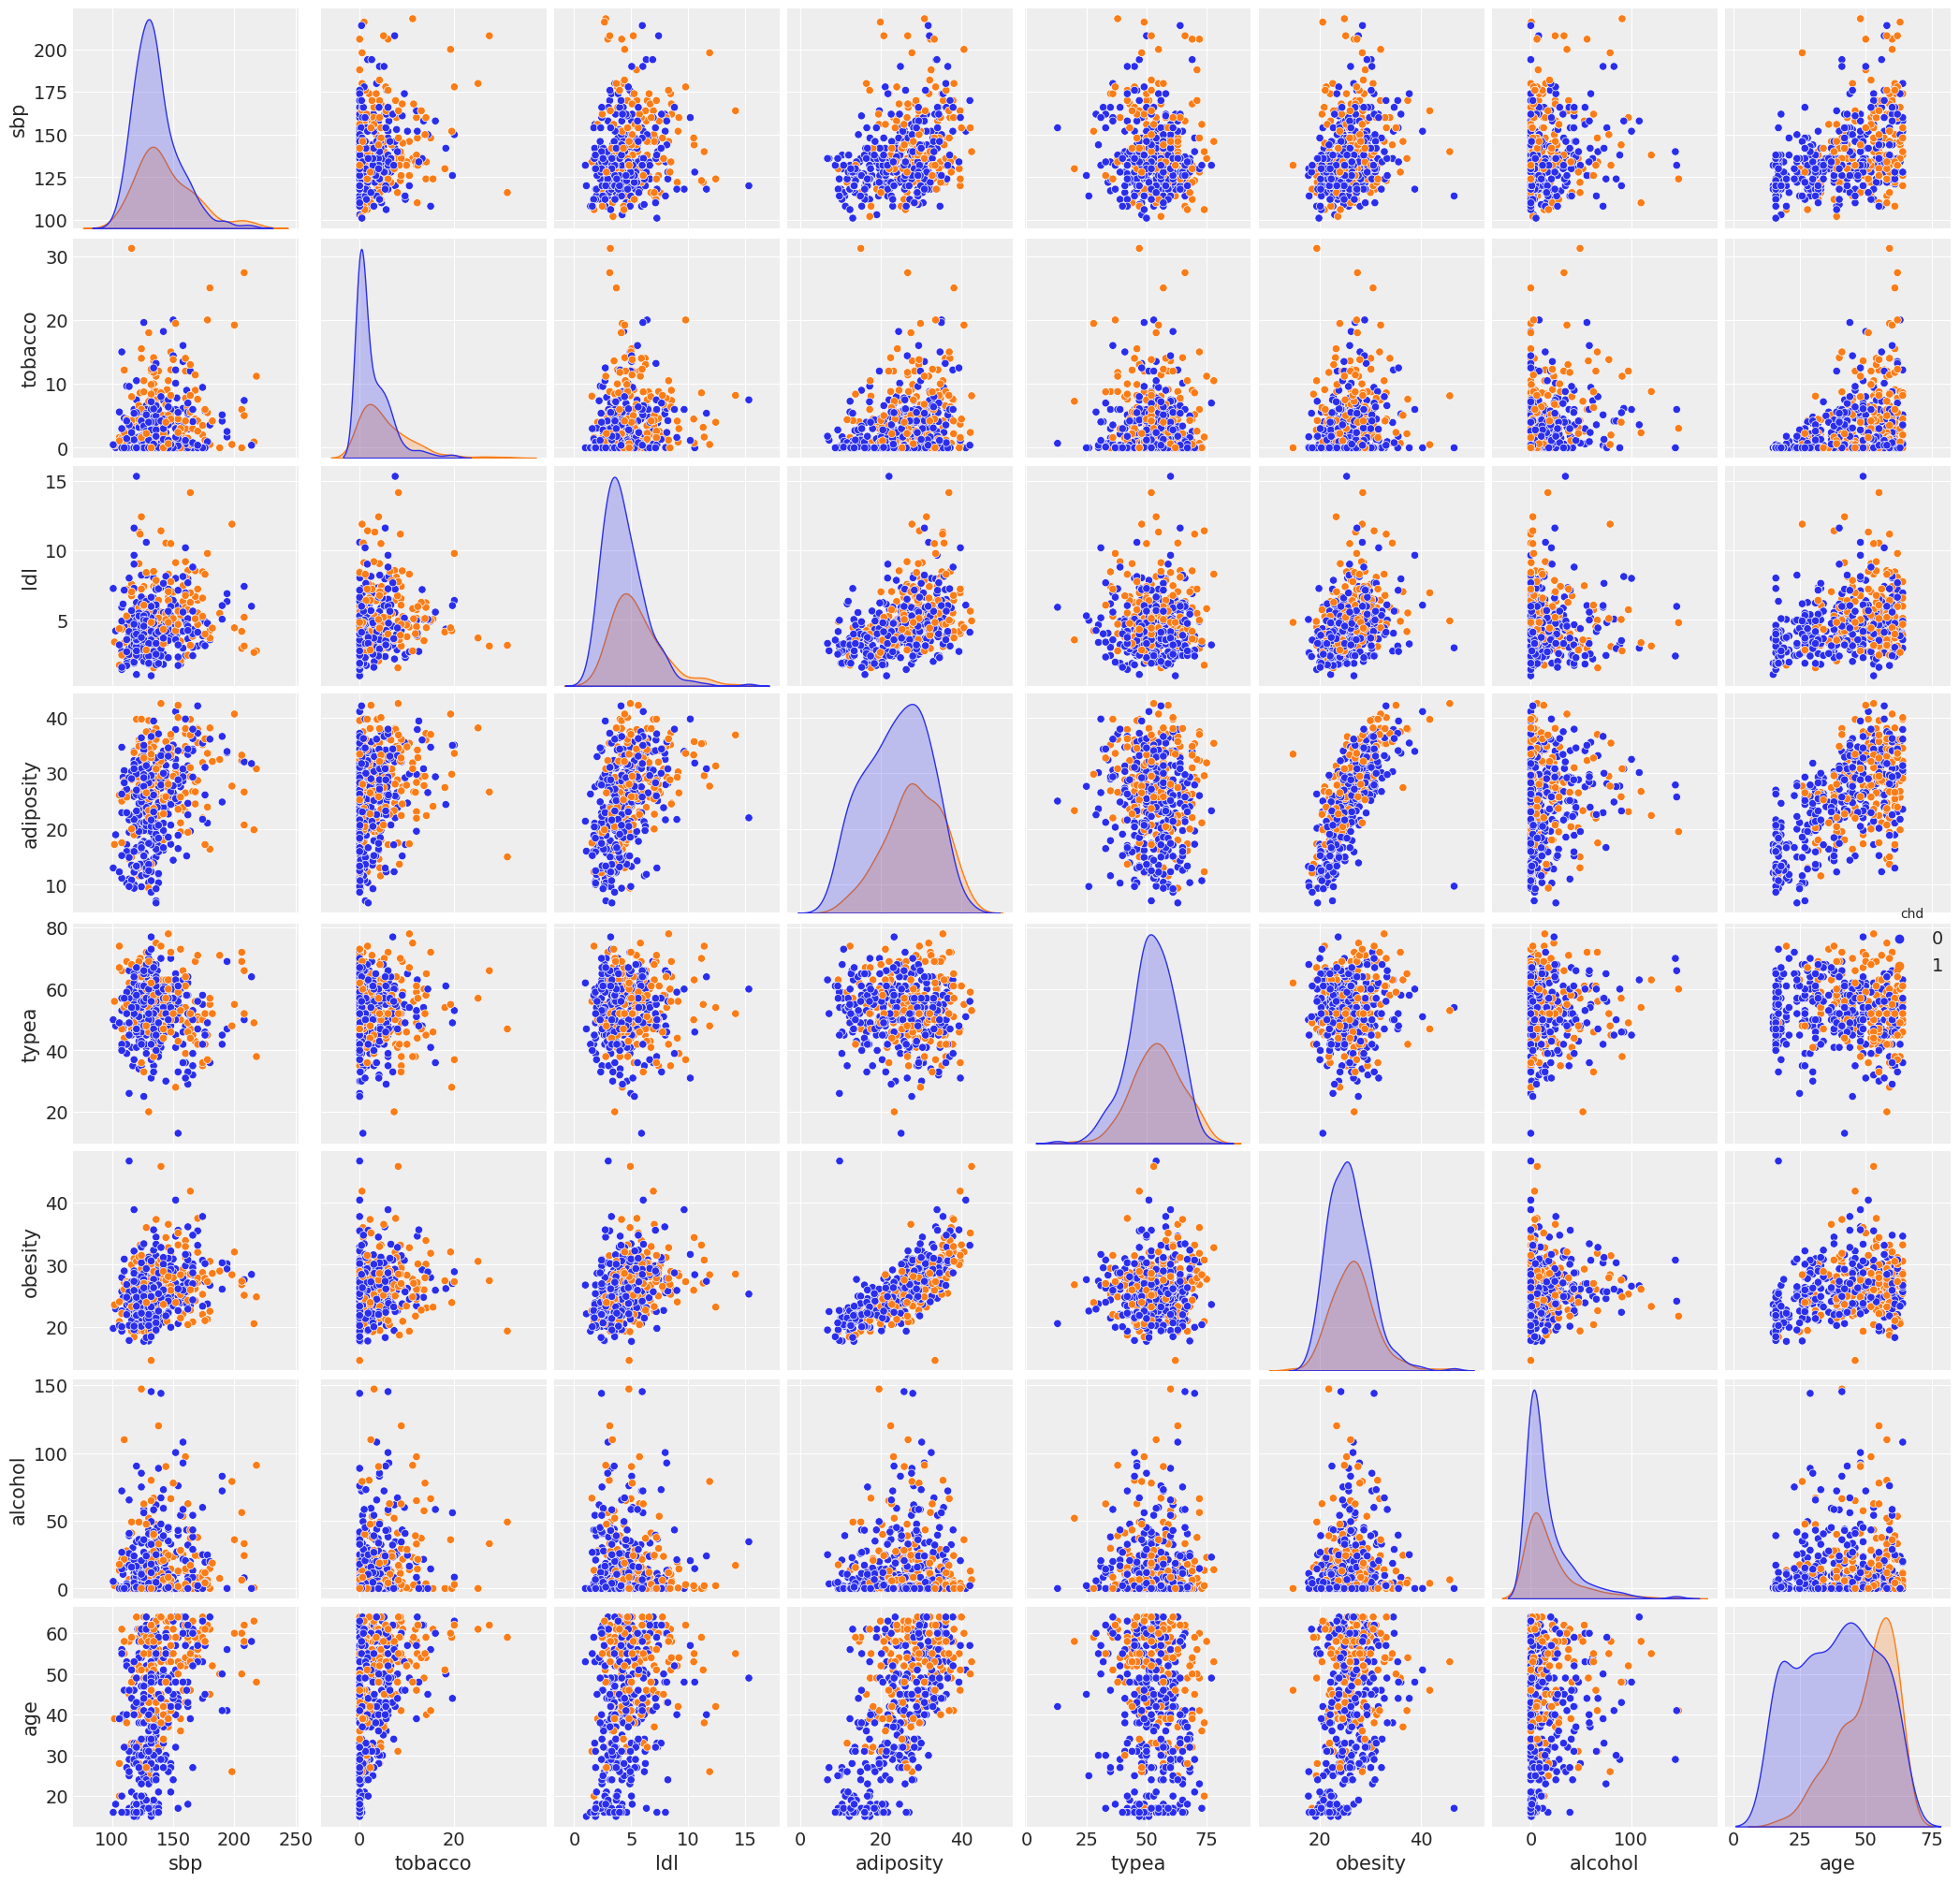

In [ ]:
sns.pairplot(data=df_chd, hue='chd',kind="scatter")

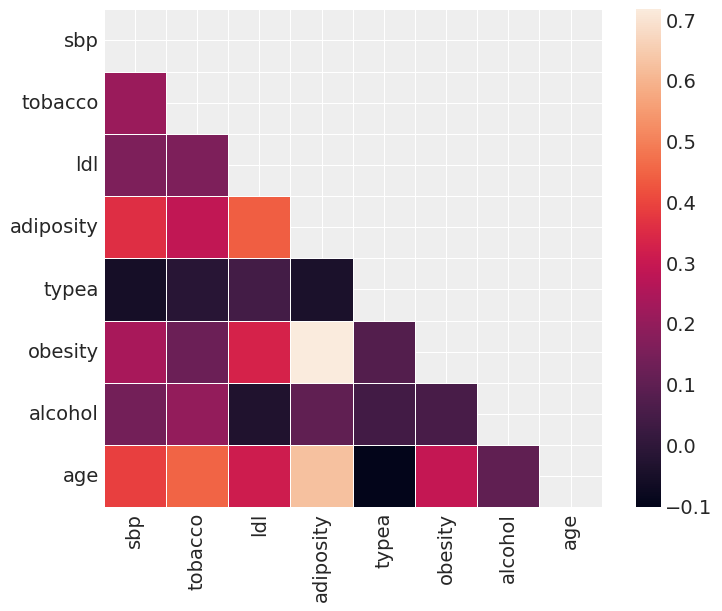

In [ ]:
# Heatkmap
corr=df_chd.iloc[:, :-1].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

ax=sns.heatmap(corr, mask=mask,
            square=True, linewidths=.5)

## Standardize the data

In [ ]:
params = ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity','alcohol', 'age']

In [ ]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [ ]:
df_chd[params] = df_chd[params].apply(standardize)
df_chd

sbp   tobacco       ldl  adiposity  famhist     typea   obesity  \
0    1.057417  1.821099  0.477894  -0.295183  Present -0.418017 -0.176594   
1    0.276789 -0.789382 -0.159507   0.411694   Absent  0.193134  0.670646   
2   -0.991731 -0.774141 -0.608585   0.883374  Present -0.112441  0.734723   
3    1.545310  0.841352  0.806252   1.622382  Present -0.214300  1.411091   
4   -0.211103  2.169453 -0.598928   0.305020  Present  0.702427 -0.012842   
..        ...       ...       ...        ...      ...       ...       ...   
457  3.692037 -0.704470  0.598614   0.811401   Absent  1.109862  0.570971   
458  2.130781  0.122871 -0.159507   0.860240   Absent -0.112441  0.608942   
459 -1.479624 -0.138395 -1.521228  -1.307946   Absent -1.334744 -1.413043   
460 -0.991731  0.384137  3.317227   0.691875   Absent  1.109862  0.309916   
461 -0.308682 -0.791559  0.038474   1.028605  Present  0.906144 -2.692210   

      alcohol       age  chd  
0    3.274189  0.628654    1  
1   -0.612081  1.381617    1  
2   -0.540597  0.217947    0  
3    0.294742  1.039361    1  
4    1.645991  0.423301    1  
..        ...       ...  ...  
457 -0.696228  1.039361    0  
458  0.068445  0.628654    1  
459  0.391960  0.834008    0  
460  0.282897 -0.192760    0  
461 -0.696228  0.217947    1  

[462 rows x 10 columns]

## Categorical values handling

In [ ]:
df_chd["famhist"] = (df_chd["famhist"] == "Present")*1
df_chd.head()

sbp   tobacco       ldl  adiposity  famhist     typea   obesity  \
0  1.057417  1.821099  0.477894  -0.295183        1 -0.418017 -0.176594   
1  0.276789 -0.789382 -0.159507   0.411694        0  0.193134  0.670646   
2 -0.991731 -0.774141 -0.608585   0.883374        1 -0.112441  0.734723   
3  1.545310  0.841352  0.806252   1.622382        1 -0.214300  1.411091   
4 -0.211103  2.169453 -0.598928   0.305020        1  0.702427 -0.012842   

    alcohol       age  chd  
0  3.274189  0.628654    1  
1 -0.612081  1.381617    1  
2 -0.540597  0.217947    0  
3  0.294742  1.039361    1  
4  1.645991  0.423301    1

## Train-test data split

In [ ]:
# Train-test split
X = df_chd.iloc[:,:-1]
y = df_chd['chd']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

## Build a logistic regression model

In [ ]:
obs_idx, _ = pd.factorize(X_train.index.get_level_values(0))

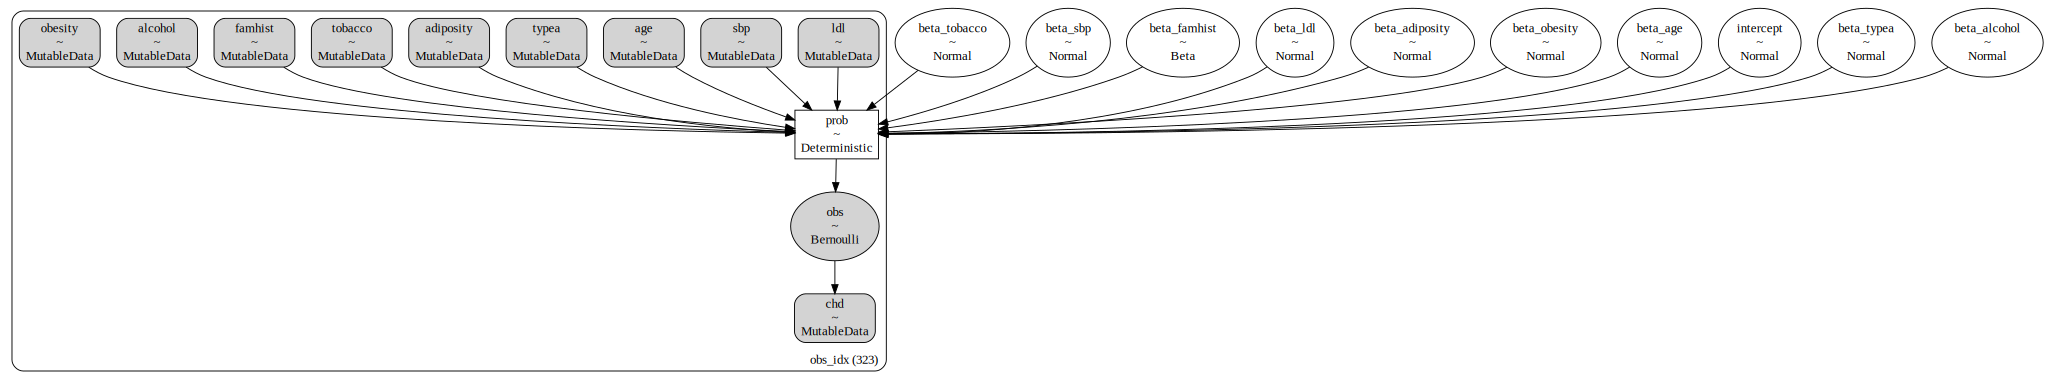

In [ ]:
mu = 0
std = 10**2

with pm.Model() as model:

    sbp_pm = pm.MutableData('sbp', X_train['sbp'], dims='obs_idx')
    tobacco_pm = pm.MutableData('tobacco', X_train['tobacco'], dims='obs_idx')
    ldl_pm = pm.MutableData('ldl', X_train['ldl'], dims='obs_idx')
    adiposity_pm = pm.MutableData('adiposity', X_train['adiposity'], dims='obs_idx')
    famhist_pm = pm.MutableData('famhist', X_train['famhist'], dims='obs_idx')
    typea_pm = pm.MutableData('typea', X_train['typea'], dims='obs_idx')
    obesity_pm = pm.MutableData('obesity', X_train['obesity'], dims='obs_idx')
    alcohol_pm = pm.MutableData('alcohol', X_train['alcohol'], dims='obs_idx')
    age_pm = pm.MutableData('age', X_train['age'], dims='obs_idx')
    chd_pm = pm.MutableData('chd', y_train, dims='obs_idx')

    intercept = pm.Normal('intercept', 0, sigma=1)
    beta_1 = pm.Normal('beta_sbp', 0, sigma=1)
    beta_2 = pm.Normal('beta_tobacco', 0, sigma=1)
    beta_3 = pm.Normal('beta_ldl', 0, sigma=1)
    beta_4 = pm.Normal('beta_adiposity', 0, sigma=1)
    beta_5 = pm.Beta('beta_famhist', alpha = 1, beta=1)
    beta_6 = pm.Normal('beta_typea', 0, sigma=1)
    beta_7 = pm.Normal('beta_obesity', 0, sigma=1)
    beta_8 = pm.Normal('beta_alcohol', 0, sigma=1)
    beta_9 = pm.Normal('beta_age', 0, sigma=1)

    mu = (intercept + beta_1 * sbp_pm + beta_2 * tobacco_pm + beta_3 * ldl_pm + beta_4 * adiposity_pm + beta_5 * famhist_pm + beta_6 * typea_pm + beta_7 * obesity_pm + beta_8 * alcohol_pm + beta_9 * age_pm)

    p = pm.Deterministic('prob',pm.math.invlogit(mu),dims='obs_idx')

    pm.Bernoulli('obs', p=p, observed=chd_pm, dims='obs_idx')


pm.model_to_graphviz(model)

In [ ]:
with model:
    idata = pm.sample(draws=25000, tune=1500)

In [ ]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

## Evaluate posterior distribution

In [ ]:
beta_params = ['intercept','beta_sbp','beta_tobacco','beta_ldl','beta_adiposity','beta_typea','beta_obesity','beta_alcohol','beta_age']

array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'beta_sbp'}>,
        <Axes: title={'center': 'beta_sbp'}>],
       [<Axes: title={'center': 'beta_tobacco'}>,
        <Axes: title={'center': 'beta_tobacco'}>],
       [<Axes: title={'center': 'beta_ldl'}>,
        <Axes: title={'center': 'beta_ldl'}>],
       [<Axes: title={'center': 'beta_adiposity'}>,
        <Axes: title={'center': 'beta_adiposity'}>],
       [<Axes: title={'center': 'beta_typea'}>,
        <Axes: title={'center': 'beta_typea'}>],
       [<Axes: title={'center': 'beta_obesity'}>,
        <Axes: title={'center': 'beta_obesity'}>],
       [<Axes: title={'center': 'beta_alcohol'}>,
        <Axes: title={'center': 'beta_alcohol'}>],
       [<Axes: title={'center': 'beta_age'}>,
        <Axes: title={'center': 'beta_age'}>]], dtype=object)

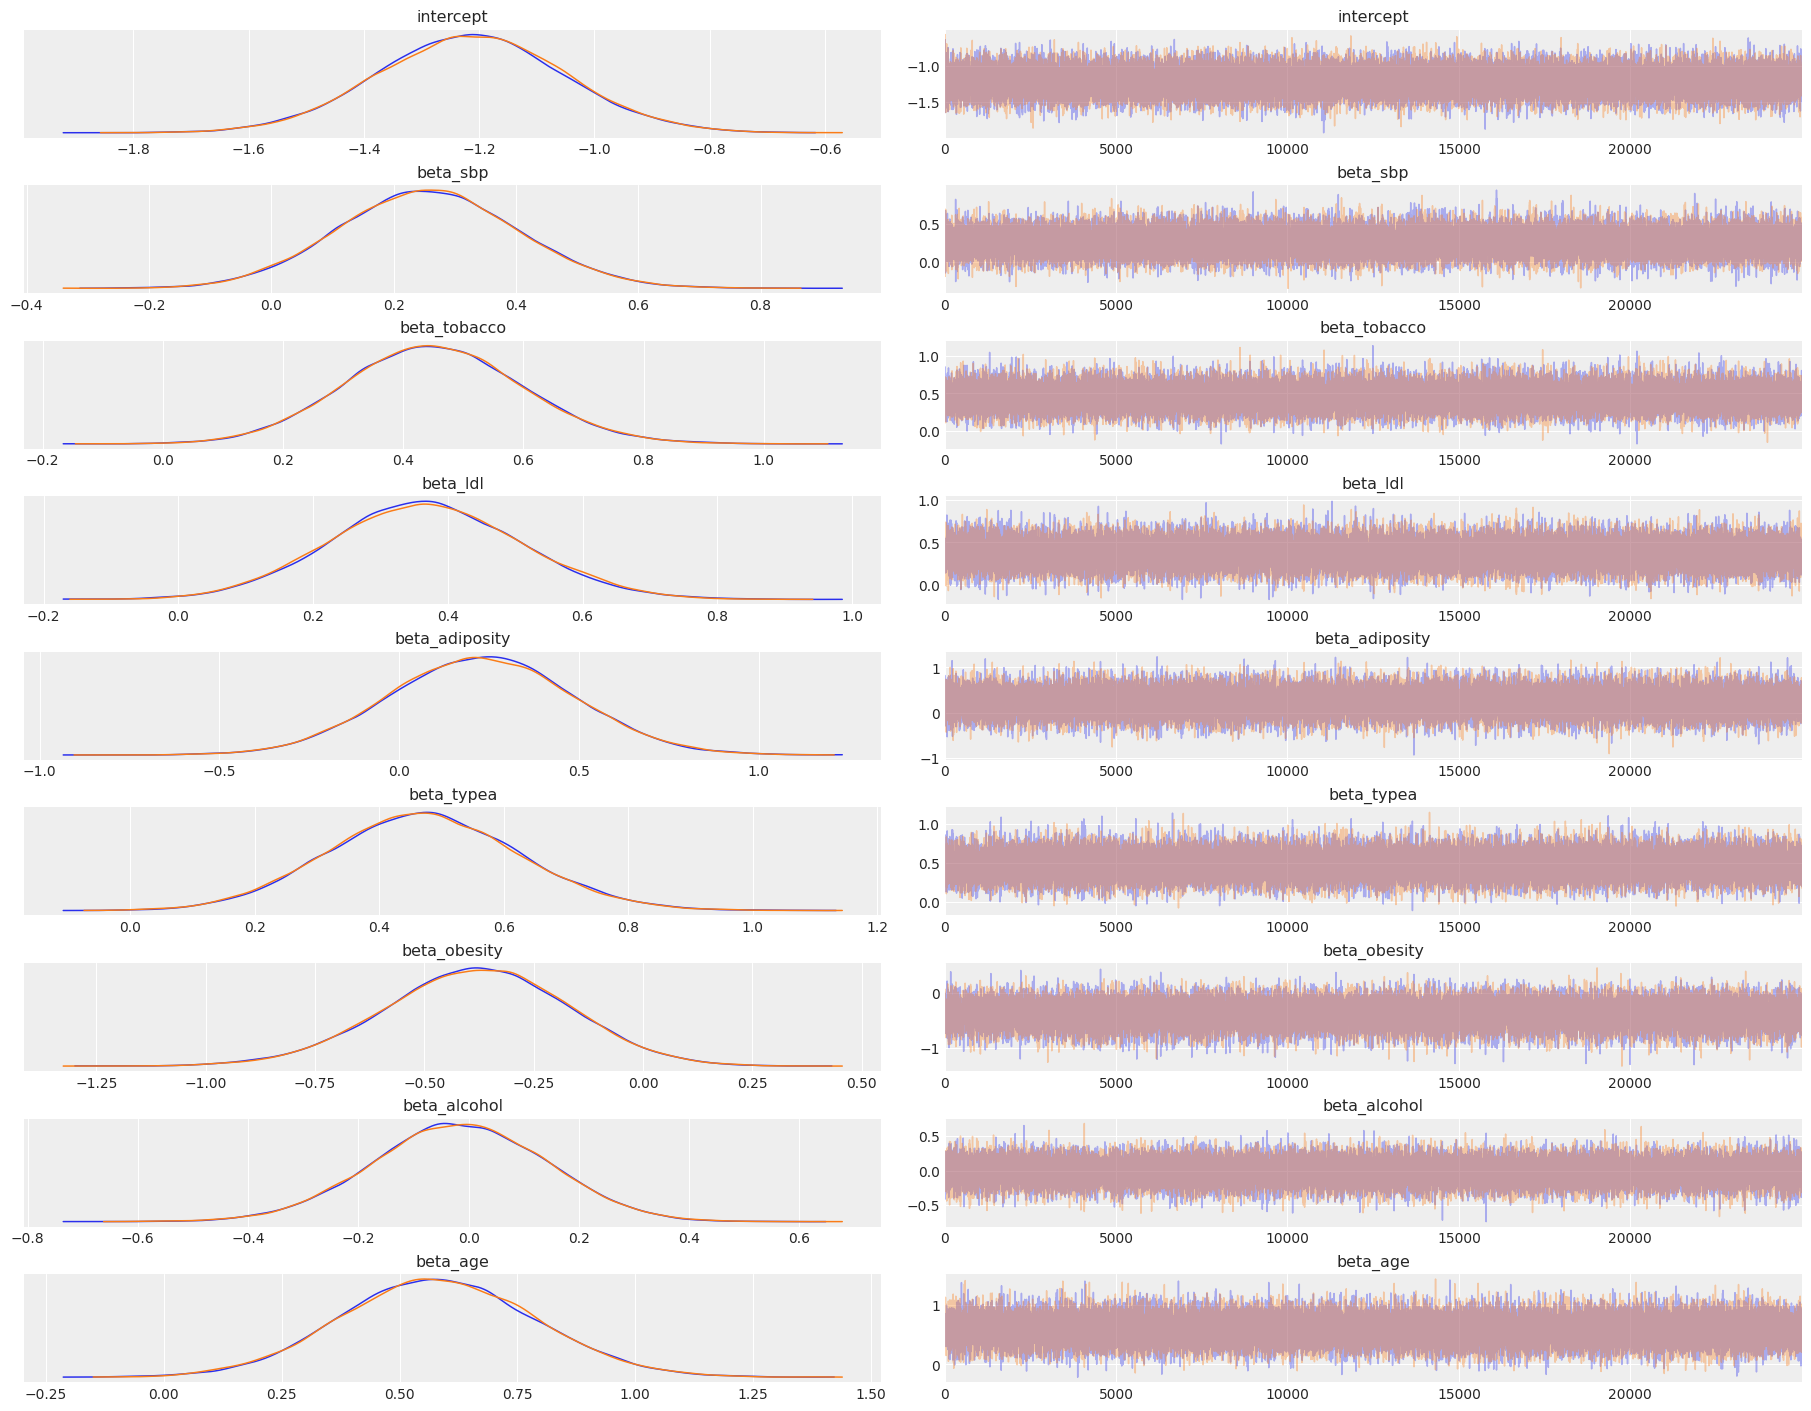

In [ ]:
az.plot_trace(idata, var_names=beta_params, compact=False,figsize=(18, 14))

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

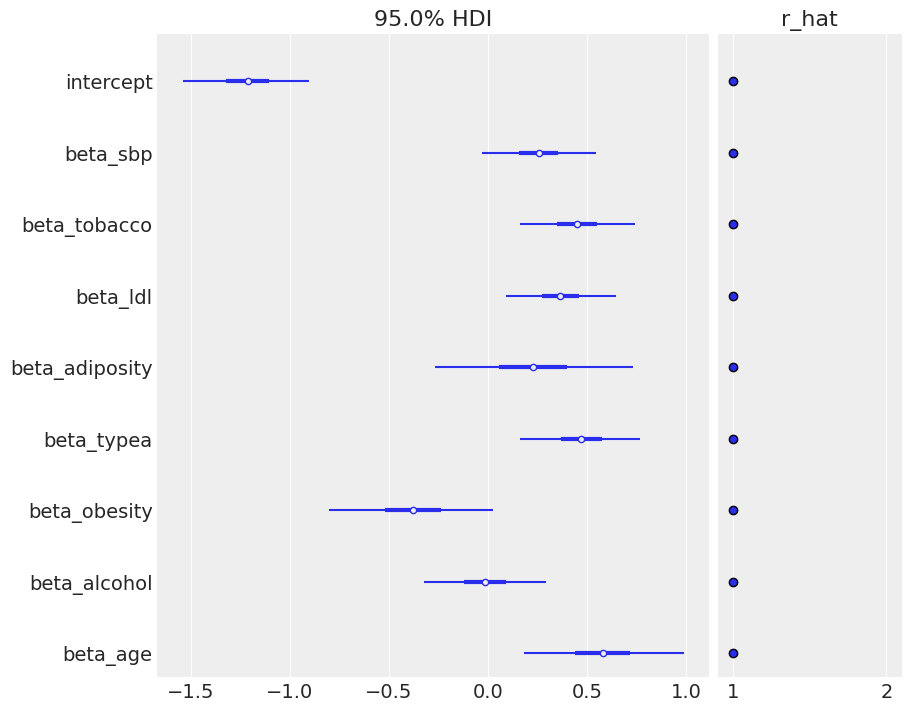

In [ ]:
az.plot_forest(idata,
               var_names=beta_params,
               combined=True,
               hdi_prob=0.95,
               r_hat=True,
               figsize=(9, 7)
               )

## Generate Out-Of-Sample

In [ ]:
with model:
    pm.set_data({'sbp': X_test['sbp'],
                 'tobacco': X_test['tobacco'],
                 'ldl': X_test['ldl'],
                 'adiposity': X_test['adiposity'],
                 'famhist': X_test['famhist'],
                 'typea': X_test['typea'],
                 'obesity': X_test['obesity'],
                 'alcohol': X_test['alcohol'],
                 'age': X_test['age'],
                 'chd': y_test})
    idata.extend(pm.sample_posterior_predictive(idata))

In [ ]:
# Compute the point prediction by taking the mean and defining the category via a threshold.
p_test_pred = idata.posterior_predictive["obs"].mean(dim=["chain", "draw"])
y_test_pred = (p_test_pred >= 0.5).astype("int")

## Model evaluation

In [ ]:
print(f"accuracy = {accuracy_score(y_true=y_test, y_pred=y_test_pred): 0.3f}")

accuracy =  0.705


# ROC

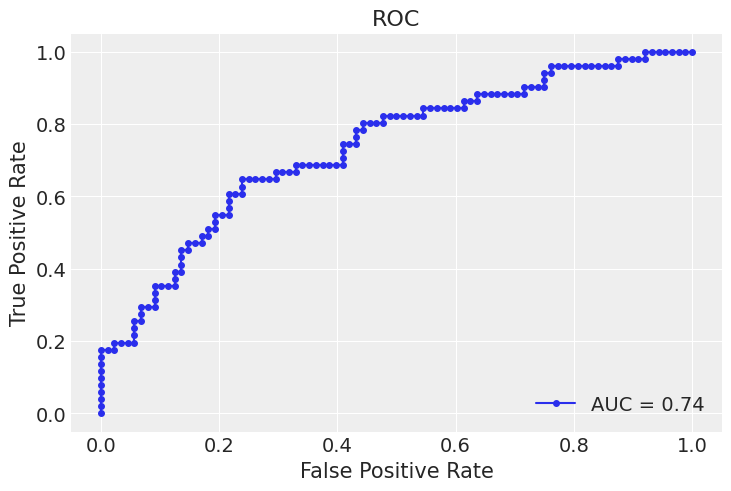

In [ ]:
fpr, tpr, thresholds = roc_curve(
    y_true=y_test, y_score=p_test_pred, pos_label=1, drop_intermediate=False
)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display = roc_display.plot(ax=ax, marker="o", markersize=4)
ax.set(title="ROC");

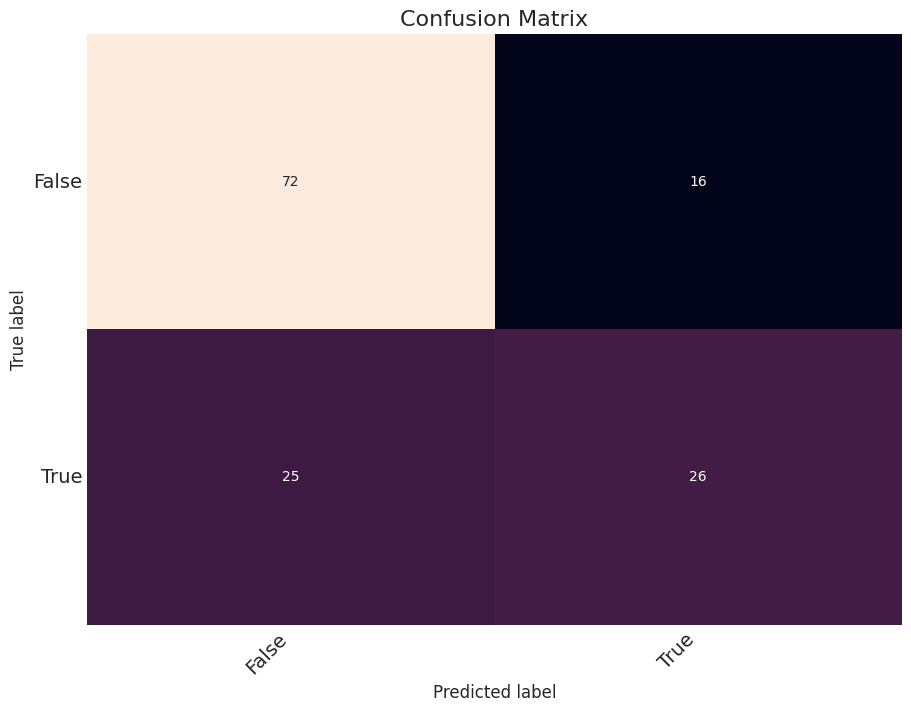

In [ ]:
print_confusion_matrix(confusion_matrix(y_test, y_test_pred), ['False', 'True'])

In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.74      0.82      0.78        88
           1       0.62      0.51      0.56        51

    accuracy                           0.71       139
   macro avg       0.68      0.66      0.67       139
weighted avg       0.70      0.71      0.70       139



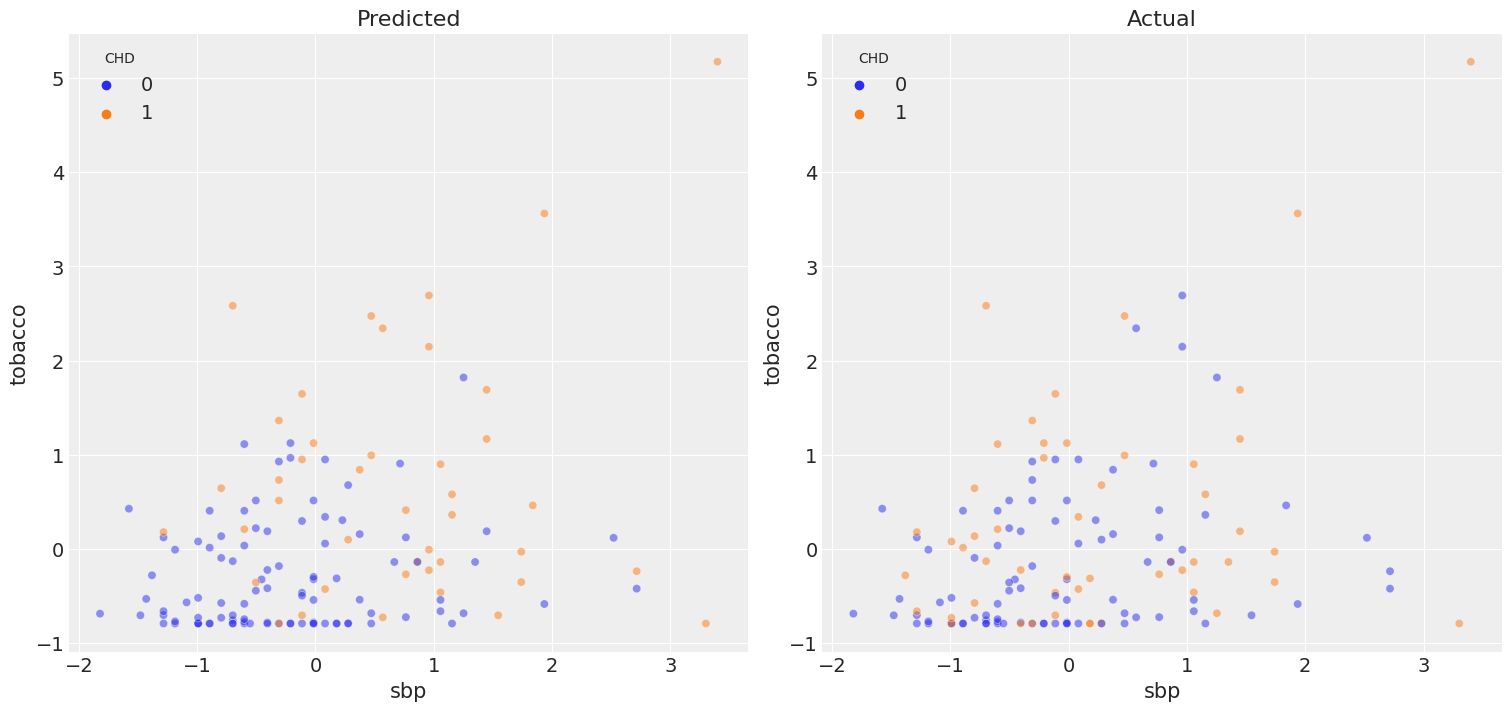

In [ ]:
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(1,2,1)
ax1 = sns.scatterplot(x = X_test['sbp'], y = X_test['tobacco'], hue = y_test_pred, alpha = 0.5)
plt.title('Predicted')
plt.legend(title='CHD')

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.scatterplot(x = X_test['sbp'], y = X_test['tobacco'], hue = y_test, alpha = 0.5)
plt.title('Actual')
plt.legend(title='CHD');

## Improvement for the CHD dataset

The accuracy 70% is not high.

Few modifications may be necessary to improve the prediction acurracy.

* test other feature transformation/scaling methods:
  * Max-min scaling
  * Log transform
  * Power transfomer scaler

* feature enginnering
  * use categorical class for SBP, for instance: normotensive, pre-hypertensiont, or hypertension etc

* prior distribution
  * test other prior distribution (more informative distribution)
